#  Import Required Libraries

In [1]:
# Step 1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')



In [2]:
dataset_dir = '.' 

train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

# Define image size and batch size for training
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
NUM_CLASSES = 4  # adenocarcinoma, large.cell.carcinoma, normal, squamous.cell.carcinoma


# Load and Preprocess Images with Data Generator

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For segmentation use None and load masks accordingly
    shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# Model Implementation


In [4]:
##  Define a U-Net Model for Image Segmentation
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_size)
    
    # Encoding path
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)
    
    # Decoding path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # For multi-class segmentation
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [5]:
model = unet_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,962,676 (7.49 MB)

 Trainable params: 1,962,676 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set up callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [7]:
# Build the CNN classification model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training and Evaluation

In [8]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=30,
        callbacks=[early_stop, checkpoint]
    )


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3380 - loss: 1.3173
Epoch 1: val_loss improved from inf to 1.09456, saving model to best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.3404 - loss: 1.3140 - val_accuracy: 0.5417 - val_loss: 1.0946
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6195 - loss: 0.8720
Epoch 2: val_loss improved from 1.09456 to 0.80835, saving model to best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.6209 - loss: 0.8701 - val_accuracy: 0.6667 - val_loss: 0.8083
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7727 - loss: 0.6043
Epoch 3: val_loss improved from 0.80835 to 0.66417, saving model to best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7732 - loss: 0.6033 - val_accuracy: 0.7361 - val_loss: 0.6642
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8435 - loss: 0.4088
Epoch 4: val_loss did not improve from 0.66417
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8435 - loss: 0.4090 - val_accuracy: 0.6667 - val_loss: 1.0001
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8558 - loss: 0.3794
Epoch 5: val_loss did not improve from 0.66417
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8560 - loss: 0.3791 - val_accuracy: 0.7500 - val_loss: 0.7595
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8998 - loss: 0.2613
Epoch 6: val_loss improved from 0.66417 to 0.62727, saving model to best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9001 - loss: 0.2613 - val_accuracy: 0.7639 - val_loss: 0.6273
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9158 - loss: 0.1944
Epoch 7: val_loss did not improve from 0.62727
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9158 - loss: 0.1945 - val_accuracy: 0.7500 - val_loss: 0.7671
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9200 - loss: 0.1854
Epoch 8: val_loss did not improve from 0.62727
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9201 - loss: 0.1860 - val_accuracy: 0.7222 - val_loss: 0.8337
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9576 - loss: 0.1115
Epoch 9: val_loss did not improve from 0.62727
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9574 - loss: 0.1117 - val_accuracy: 0.8194 - val_loss: 0.7507
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9699 - loss: 0.0907
Epoch 10: val_loss improved from 0.62727 to 0.

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9699 - loss: 0.0909 - val_accuracy: 0.8056 - val_loss: 0.5857
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9533 - loss: 0.1466
Epoch 11: val_loss did not improve from 0.58568
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9534 - loss: 0.1463 - val_accuracy: 0.8333 - val_loss: 0.6902
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9686 - loss: 0.0901
Epoch 12: val_loss did not improve from 0.58568
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9687 - loss: 0.0900 - val_accuracy: 0.8194 - val_loss: 0.6642
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9896 - loss: 0.0583
Epoch 13: val_loss did not improve from 0.58568
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9895 - loss: 0.0587 - val_accuracy: 0.8194 - val_loss: 0.7652
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9728 - loss: 0.0682
Epoch 14: val_loss did not improve from 

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9686 - loss: 0.1245 - val_accuracy: 0.8472 - val_loss: 0.5596
Epoch 16/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9947 - loss: 0.0386
Epoch 16: val_loss did not improve from 0.55957
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9946 - loss: 0.0389 - val_accuracy: 0.7778 - val_loss: 0.7300
Epoch 17/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9883 - loss: 0.0322
Epoch 17: val_loss did not improve from 0.55957
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9881 - loss: 0.0325 - val_accuracy: 0.8056 - val_loss: 1.0129
Epoch 18/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9863 - loss: 0.0419
Epoch 18: val_loss did not improve from 0.55957
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9863 - loss: 0.0420 - val_accuracy: 0.8472 - val_loss: 0.8784
Epoch 19/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9830 - loss: 0.0782
Epoch 19: val_loss did not improve from 

In [9]:
## Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1591 - loss: 13.0121
Test Loss: 8.0304
Test Accuracy: 0.4413


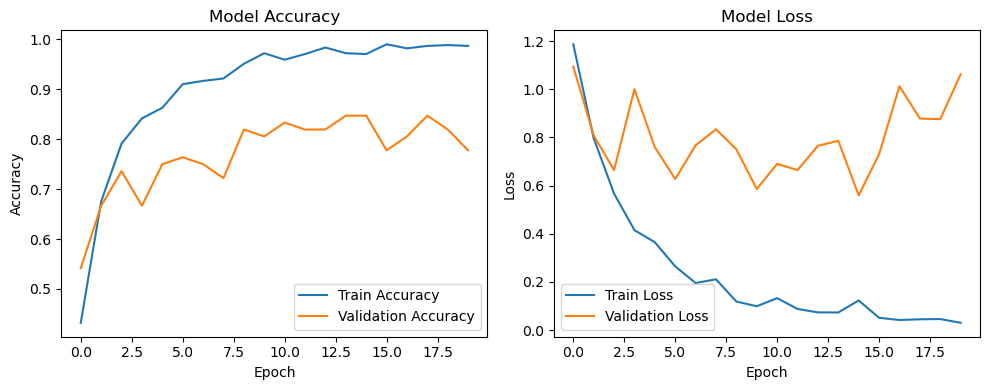

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


<Figure size 800x600 with 0 Axes>

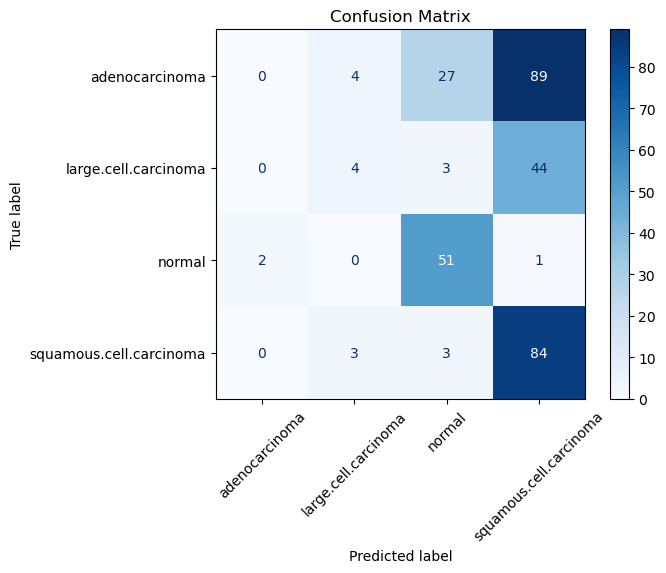

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes on entire test set
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [12]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.00      0.00      0.00       120
   large.cell.carcinoma       0.36      0.08      0.13        51
                 normal       0.61      0.94      0.74        54
squamous.cell.carcinoma       0.39      0.93      0.55        90

               accuracy                           0.44       315
              macro avg       0.34      0.49      0.35       315
           weighted avg       0.27      0.44      0.30       315



# Practical Application

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


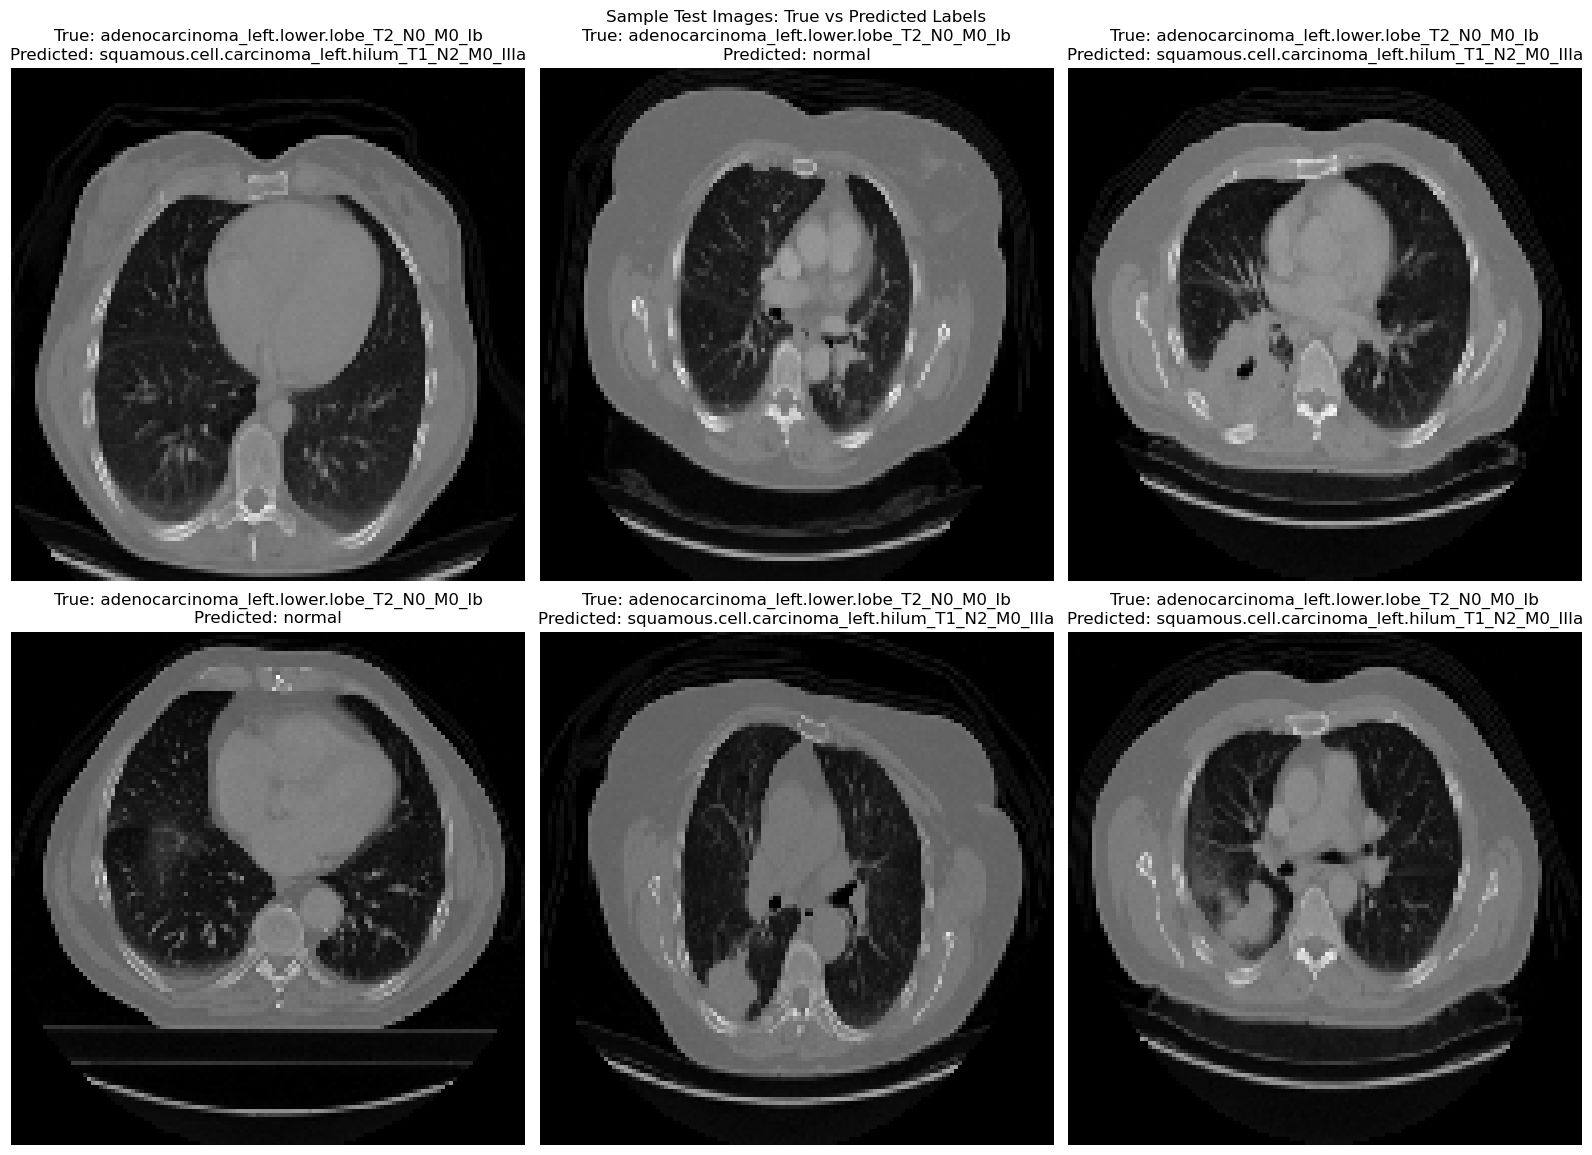

In [15]:
import numpy as np
import matplotlib.pyplot as plt

test_images, test_labels = next(test_generator)
preds = model.predict(test_images)
predicted_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(16, 12))
for i in range(6):  # Show 6 images
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_labels[true_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')
plt.suptitle('Sample Test Images: True vs Predicted Labels')
plt.tight_layout()
plt.show()
